In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [3]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [4]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
device

device(type='cuda')

In [7]:
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

Epoch [1/10], Loss: 1.7426
Epoch [2/10], Loss: 1.4175
Epoch [3/10], Loss: 1.2905
Epoch [4/10], Loss: 1.1956
Epoch [5/10], Loss: 1.1183
Epoch [6/10], Loss: 1.0719
Epoch [7/10], Loss: 1.0343
Epoch [8/10], Loss: 0.9863
Epoch [9/10], Loss: 0.9518
Epoch [10/10], Loss: 0.9257


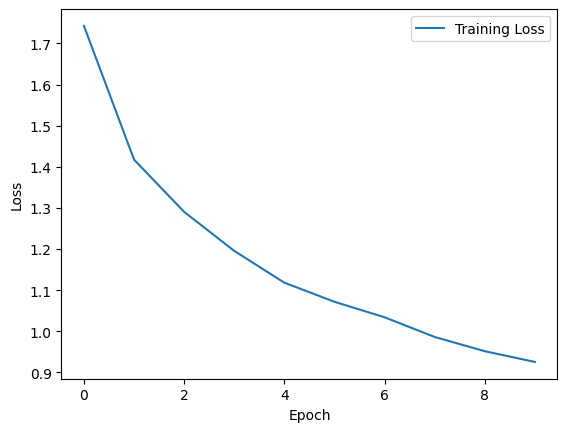

In [8]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

Accuracy of the model on the test images: 66.77%


In [12]:
# save model
torch.save(model.state_dict(), f'saved_models/alexnet_cifar10_{datetime.now().strftime("%Y%m%d%H%M%S")}.pth')